# Face Recognition using Eigen Faces
## Team 21  :    AGGIN
### Members:
* Aakash Reddy  - 2020102034
* Prasoon Garg  - 2020102049
* Siddhant Garg - 2020112006
* Anubhav Pal   - 2020112012

Link to paper: https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf

### Importing Libraries

In [1]:
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy import stats
import cv2
from PIL import Image

In [2]:
%matplotlib inline
random.seed(142) # for reproducibility, set a random seed

### Loading the images and labels for train and test dataset

In [3]:
dataset_path = 'YaleDataset/'
dataset_dir  = os.listdir(dataset_path)
WIDTH  = 64   
HEIGHT = 64   
DIM = 20
# DIM = 1000

In [4]:
def funct1(training_im, testing_im, training_label, testing_label, types):
    for i in range(1,16):
        im = {}
        testing_type = random.sample(types, 2)
        for t in types:
            im[t] = np.array(Image.open(dataset_path+"subject"+str(i).zfill(2)+"."+t),'uint8')
            im[t] = cv2.resize(im[t], (WIDTH,HEIGHT), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
            if t in testing_type:
                testing_im.append(im[t])
                testing_label.append(i)
            else:
                training_im.append(im[t])
                training_label.append(i)
    return training_im, testing_im, training_label, testing_label

In [5]:
def load_images():
    training_im, testing_im, training_label, testing_label = [], [], [], []
    types = ["centerlight", "glasses", "happy", "leftlight", "noglasses",
             "normal", "rightlight", "sad", "sleepy", "surprised", "wink"]
    funct1(training_im, testing_im, training_label, testing_label, types)
    
    return np.array(training_im), np.array(training_label), np.array(testing_im), np.array(testing_label)

In [6]:
training_im, training_label, testing_im, testing_label = load_images()

## Get Training Tensor, Mean Face and Normalised Face Vector

In [7]:
def tensor(im):
    training_tensor = training_im.reshape((training_im.shape[0],-1))
    mean_face = np.mean(training_tensor,axis=0)
    normalised_training_tensor = training_tensor-mean_face
    return normalised_training_tensor, mean_face, training_tensor

normalised_training_tensor, mean_face, training_tensor = tensor(training_im)

## Eigenvectors and values

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(np.cov(normalised_training_tensor) / training_im.shape[0])

In [9]:
size = eigenvalues.shape[0]

eig_pairs = []

for i in range(size):
    eig_pairs.append([eigenvalues[i], eigenvectors[:,i]])

sorted(eig_pairs, reverse=True)
         
eigvalues_sort = []
eigvectors_sort = []
    
for i in range(size):
    eigvalues_sort.append(eig_pairs[i][0])
    eigvectors_sort.append(eig_pairs[i][1])
    
eigvalues_sort = np.array(eigvalues_sort)
eigvectors_sort = np.array(eigvectors_sort)

### Plotting percentage of variance for each eigenvector

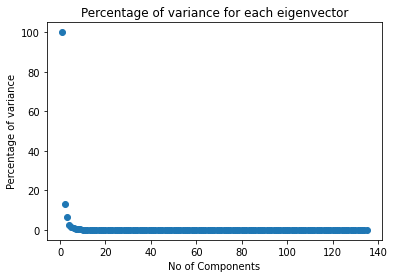

In [10]:
eigenvalues_var = (eigenvalues**2)/eigenvalues.shape[0]
eigenvalues_var_comp = eigenvalues_var / eigenvalues_var.shape[0]
plt.title('Percentage of variance for each eigenvector')
plt.xlabel('No of Components')
plt.ylabel('Percentage of variance')
plt.scatter(np.arange(1,eigenvalues.shape[0]+1), np.abs(eigenvalues_var_comp))
#plt.savefig('Percentage of variance for each eigenvector.png')
plt.show()

### Normalised Cumulative sorted eigenvalues for the eigenvectors

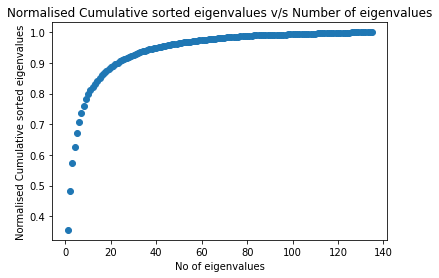

In [11]:
var_comp_sum = np.cumsum(eigvalues_sort) / np.sum(eigvalues_sort)

plt.title('Normalised Cumulative sorted eigenvalues v/s Number of eigenvalues')
plt.xlabel('No of eigenvalues')
plt.ylabel('Normalised Cumulative sorted eigenvalues')
plt.scatter(np.arange(1,eigenvalues.shape[0]+1), np.abs(var_comp_sum))
# plt.savefig('Normalised Cumulative sorted eigenvalues v/s Number of eigenvalues.png')
plt.show()

## Dimensionality Reduction

In [12]:
reduced_data = np.array(eigvectors_sort[:DIM]).T
proj_data = (training_tensor.T @ reduced_data).T
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])

## Recogniser function

In [13]:
def recogniser(curr_testing_im, curr_testing_label, proj_data, w, K, printflg=False, t0 = 30543585,t1 = 54827804):
    
    unknown_face = curr_testing_im
    unknown_face_vector = np.array(curr_testing_im, dtype='float64').flatten()
    normalised_uface_vector = unknown_face_vector-mean_face
    w_unknown = proj_data @ normalised_uface_vector
    norms = np.linalg.norm(w - w_unknown, axis=1)
    index = np.argsort(norms)
    
    closestindex = {}
    for i in index:
        lab = training_label[i]
        if lab in closestindex:
            continue
        closestindex[lab] = i
    
    label_index = training_label[index]
    topklabels = stats.mode(label_index[:K])
    index = closestindex[topklabels[0].item()]
    if printflg:
        print(f"Detected image from training images index {index} and distance value {norms[index]}")

    if norms[index] < t1: # It's a face
        if norms[index] < t0: # Face recognised
            if printflg:
                print("Face recognised and found a match in the dataset")
            return training_label[index], training_im[index]
        else:
            if printflg:
                print("Face detected, but did not find it in the dataset")
            return -1, None
    else:
        if printflg:
            print("Face not detected")
        return -2, None

### Plot accuracy of recognition v/s K in K-Nearest-Neighbours Classifier

C:\Users\Aakash Reddy\AppData\Local\Temp\ipykernel_23428\3105832936.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  topklabels = stats.mode(label_index[:K])


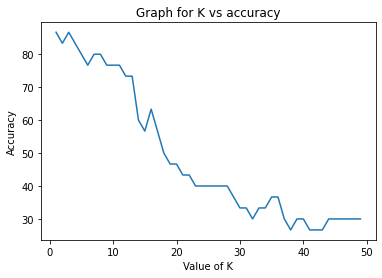

In [14]:
n = 50
k = range(1, n)
acc = []

for i in range(1, n):
    ROW_SIZE = 5
    correct_pred = 0
    for idx, curr_testing_im in enumerate(testing_im):
        label, im = recogniser(curr_testing_im, testing_label[idx], proj_data, w, i)
        if label == testing_label[idx]:
            correct_pred += 1
    # print(f"\nTrying for K = {i}")
    # print('Correct predictions: {}/{} = {}%'.format(correct_pred, testing_im.shape[0], correct_pred/testing_im.shape[0]*100))
    acc.append(correct_pred/testing_im.shape[0]*100)
plt.plot(k, acc)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.title("Graph for K vs accuracy")
plt.show()

## Displaying Result on the testing dataset

-------------
For testing image 0:

Detected image from training images index 1 and distance value 3183092.2911567427
Face recognised and found a match in the dataset

The prediction is correct


C:\Users\Aakash Reddy\AppData\Local\Temp\ipykernel_23428\3105832936.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  topklabels = stats.mode(label_index[:K])


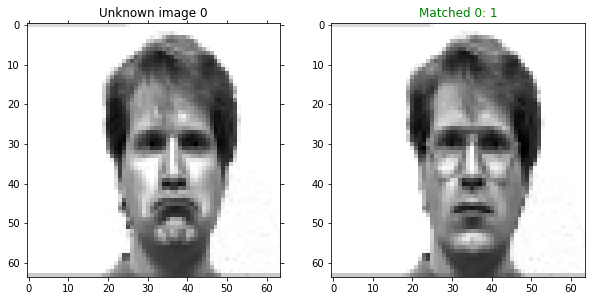

-------------
For testing image 1:

Detected image from training images index 8 and distance value 4480610.327699836
Face recognised and found a match in the dataset

The prediction is correct


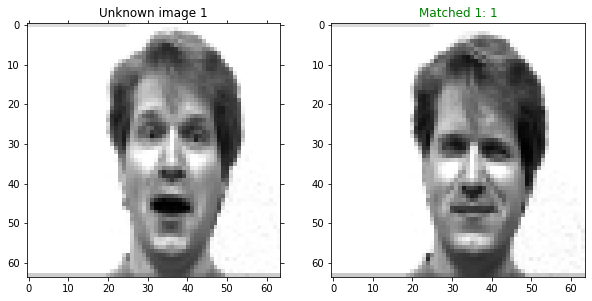

-------------
For testing image 2:

Detected image from training images index 12 and distance value 6928655.7710378375
Face recognised and found a match in the dataset

The prediction is correct


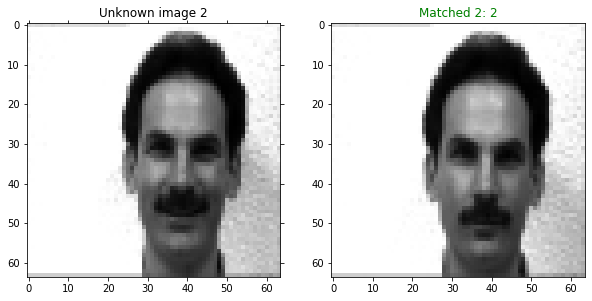

-------------
For testing image 3:

Detected image from training images index 13 and distance value 3513706.6710747583
Face recognised and found a match in the dataset

The prediction is correct


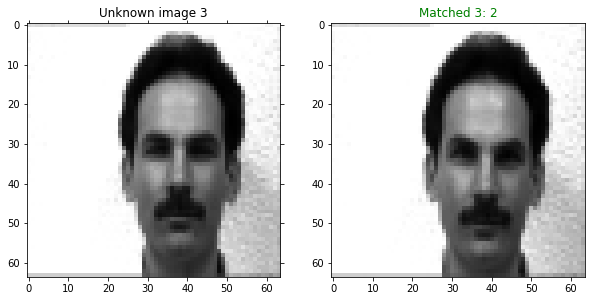

-------------
For testing image 4:

Detected image from training images index 20 and distance value 3612688.4258670723
Face recognised and found a match in the dataset

The prediction is correct


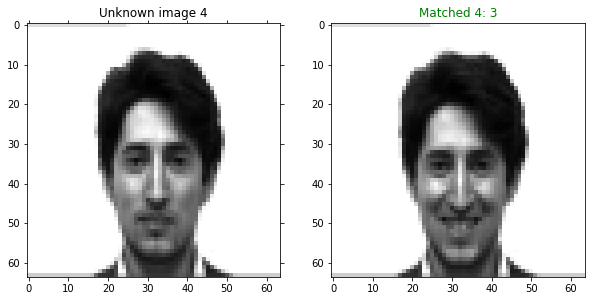

-------------
For testing image 5:

Detected image from training images index 20 and distance value 3612688.4258670723
Face recognised and found a match in the dataset

The prediction is correct


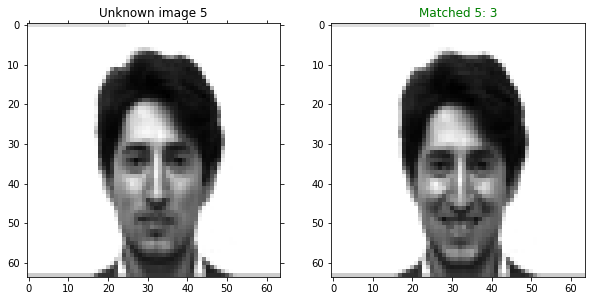

-------------
For testing image 6:

Detected image from training images index 35 and distance value 5973171.166343895
Face recognised and found a match in the dataset

The prediction is correct


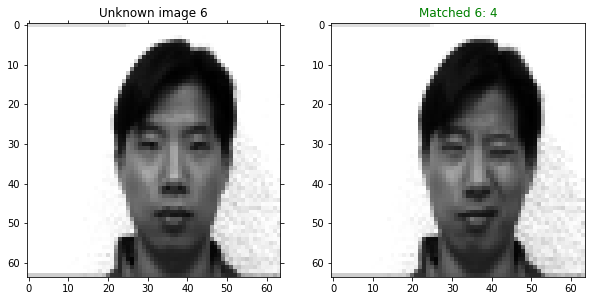

-------------
For testing image 7:

Detected image from training images index 32 and distance value 0.0
Face recognised and found a match in the dataset

The prediction is correct


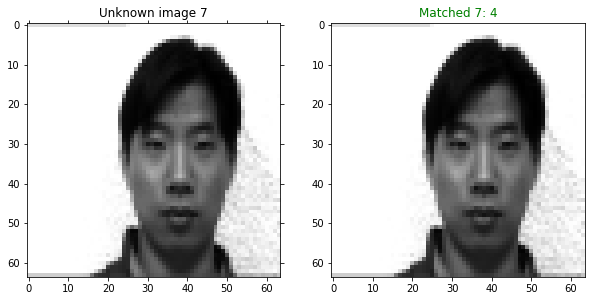

-------------
For testing image 8:

Detected image from training images index 43 and distance value 10267590.345902938
Face recognised and found a match in the dataset

The prediction is correct


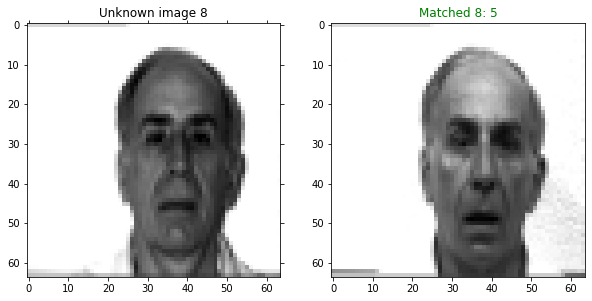

-------------
For testing image 9:

Detected image from training images index 44 and distance value 1762407.5204594934
Face recognised and found a match in the dataset

The prediction is correct


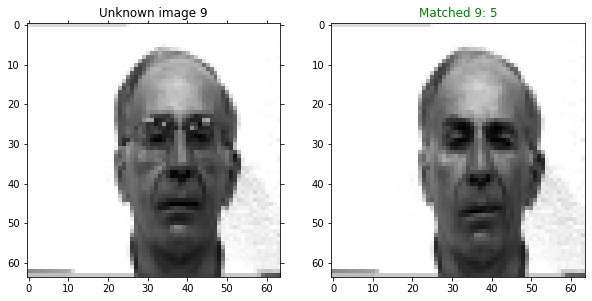

-------------
For testing image 10:

Detected image from training images index 48 and distance value 3872109.0225028726
Face recognised and found a match in the dataset

The prediction is correct


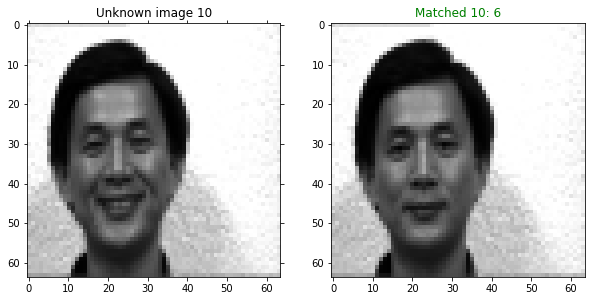

-------------
For testing image 11:

Detected image from training images index 48 and distance value 0.0
Face recognised and found a match in the dataset

The prediction is correct


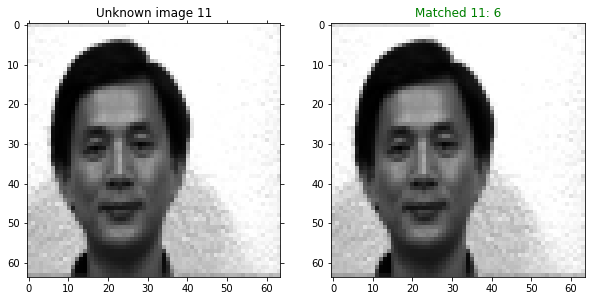

-------------
For testing image 12:

Detected image from training images index 58 and distance value 2112054.5404110155
Face recognised and found a match in the dataset

The prediction is correct


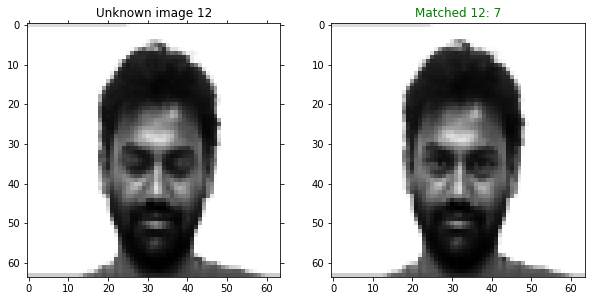

-------------
For testing image 13:

Detected image from training images index 62 and distance value 5985130.22693991
Face recognised and found a match in the dataset

The prediction is correct


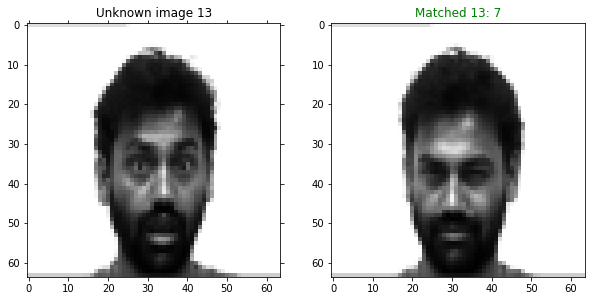

-------------
For testing image 14:

Detected image from training images index 57 and distance value 36686210.50561332
Face detected, but did not find it in the dataset

The prediction is incorrect


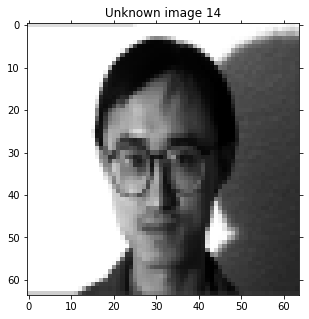

-------------
For testing image 15:

Detected image from training images index 114 and distance value 15047545.098104378
Face recognised and found a match in the dataset

The prediction is incorrect


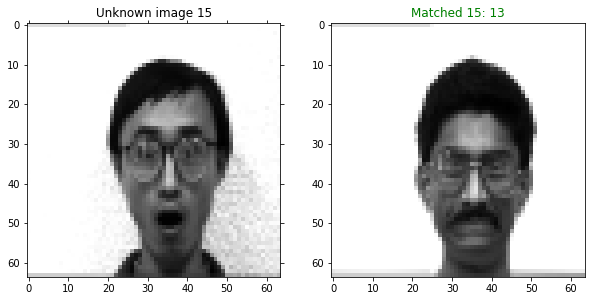

-------------
For testing image 16:

Detected image from training images index 23 and distance value 22095503.527492598
Face recognised and found a match in the dataset

The prediction is incorrect


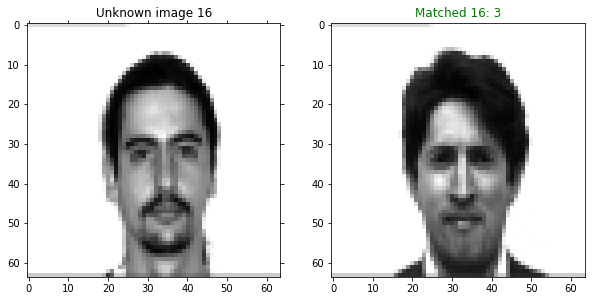

-------------
For testing image 17:

Detected image from training images index 79 and distance value 7064129.91625091
Face recognised and found a match in the dataset

The prediction is correct


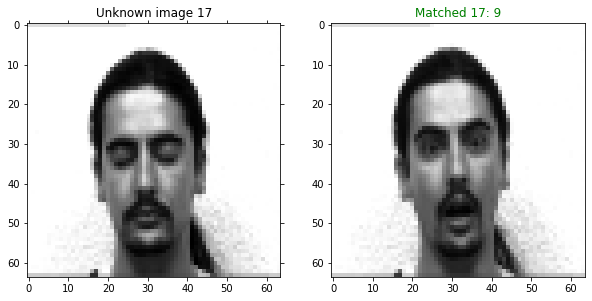

-------------
For testing image 18:

Detected image from training images index 3 and distance value 23802670.33221402
Face recognised and found a match in the dataset

The prediction is incorrect


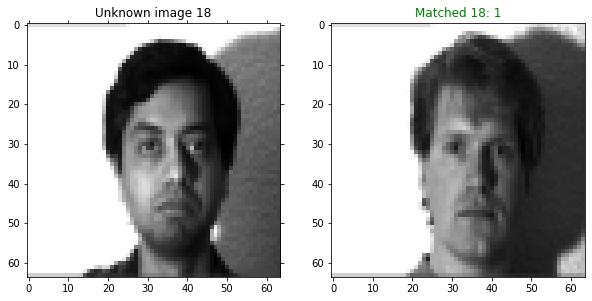

-------------
For testing image 19:

Detected image from training images index 83 and distance value 1550672.9116215187
Face recognised and found a match in the dataset

The prediction is correct


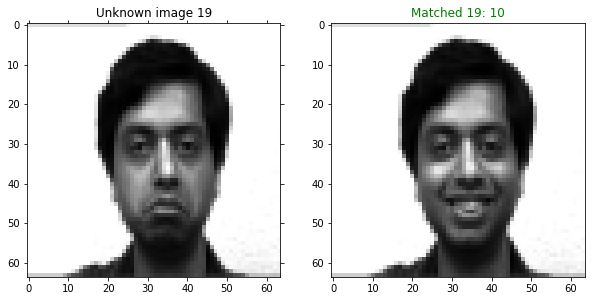

-------------
For testing image 20:

Detected image from training images index 90 and distance value 13867886.235481732
Face recognised and found a match in the dataset

The prediction is correct


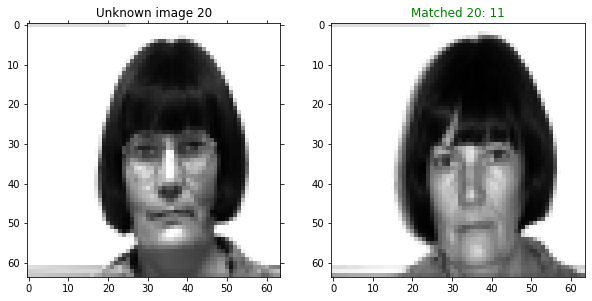

-------------
For testing image 21:

Detected image from training images index 97 and distance value 6326534.4508672645
Face recognised and found a match in the dataset

The prediction is correct


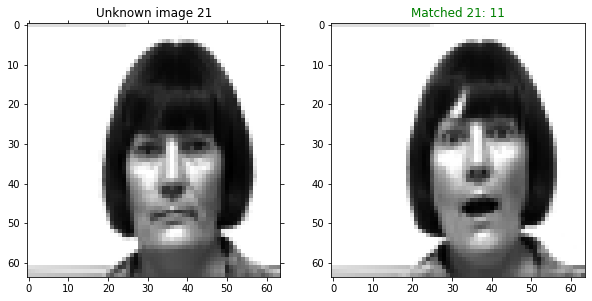

-------------
For testing image 22:

Detected image from training images index 103 and distance value 0.0
Face recognised and found a match in the dataset

The prediction is correct


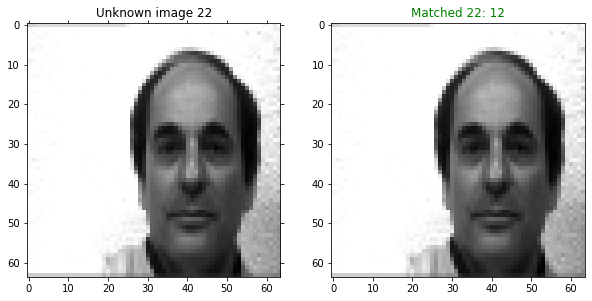

-------------
For testing image 23:

Detected image from training images index 105 and distance value 5652886.166012003
Face recognised and found a match in the dataset

The prediction is correct


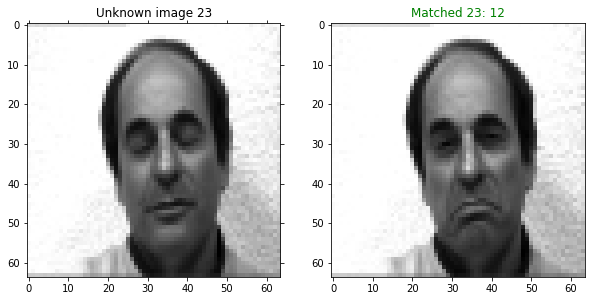

-------------
For testing image 24:

Detected image from training images index 114 and distance value 2852871.225771311
Face recognised and found a match in the dataset

The prediction is correct


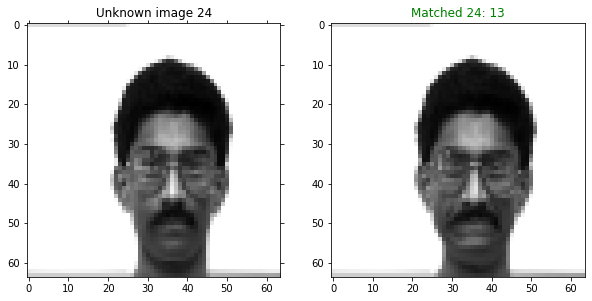

-------------
For testing image 25:

Detected image from training images index 109 and distance value 4009881.252521673
Face recognised and found a match in the dataset

The prediction is correct


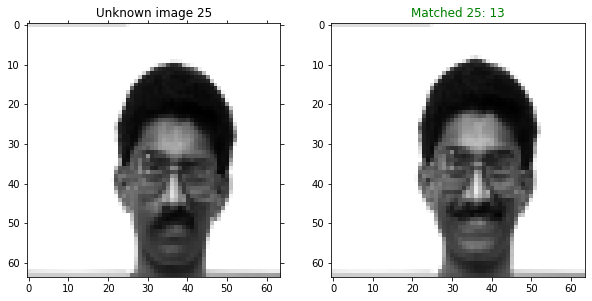

-------------
For testing image 26:

Detected image from training images index 118 and distance value 6874832.136900651
Face recognised and found a match in the dataset

The prediction is correct


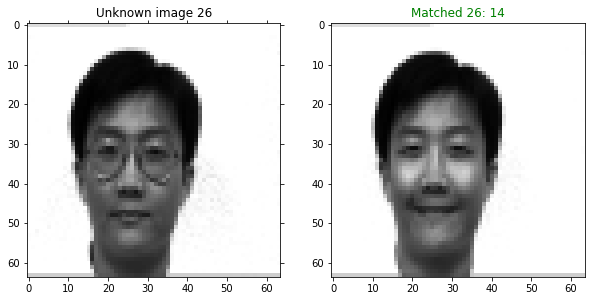

-------------
For testing image 27:

Detected image from training images index 118 and distance value 5436584.341956038
Face recognised and found a match in the dataset

The prediction is correct


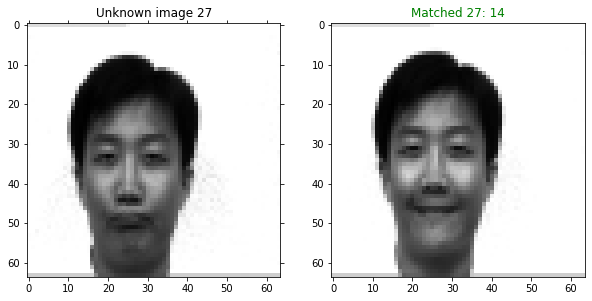

-------------
For testing image 28:

Detected image from training images index 131 and distance value 4148097.2637598068
Face recognised and found a match in the dataset

The prediction is correct


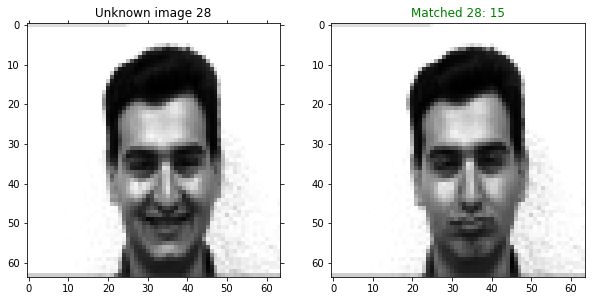

-------------
For testing image 29:

Detected image from training images index 133 and distance value 3522388.583761499
Face recognised and found a match in the dataset

The prediction is correct


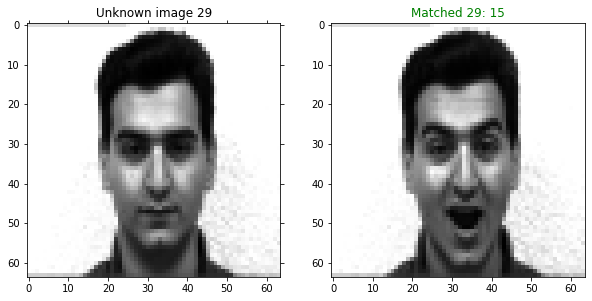

-------------
Accuracy: 26/30 = 86.66666666666667%


In [15]:
ROW_SIZE = 5
correct_pred = 0
print("-------------")
for idx, curr_testing_im in enumerate(testing_im):
    print(f"For testing image {idx}:\n")
    label, im = recogniser(curr_testing_im, testing_label[idx], proj_data, w, 3, True)
    if label == testing_label[idx]:
        print("\nThe prediction is correct")
        correct_pred += 1
    else:
        print("\nThe prediction is incorrect")
    if label >= 0:
        fig,ax = plt.subplots(ncols=2,figsize=(ROW_SIZE*2,ROW_SIZE))
        ax[0].imshow(curr_testing_im, cmap='gray')
        ax[0].set_title(f'Unknown image {idx}')
        ax[0].tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='on',left='off', which='both')
        ax[1].set_title(f'Matched {idx}: {label}', color='g')
        ax[1].imshow(im, cmap='gray')
    else:
        plt.figure(figsize=(ROW_SIZE,ROW_SIZE))
        plt.imshow(curr_testing_im, cmap='gray')
        plt.title(f'Unknown image {idx}')
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='on',left='off', which='both')
    plt.show()
    print("-------------")
    
print('Accuracy: {}/{} = {}%'.format(correct_pred, testing_im.shape[0], correct_pred/testing_im.shape[0]*100))


### Loading new images of unseen faces and objects

In [16]:
def load(im, new_testing_im, new_testing_label):
    for i in os.listdir("YaleDataset/testing_set"):
        im = np.array(Image.open("YaleDataset/testing_set/"+i),'uint8')
        if len(im.shape) == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = cv2.resize(im, (WIDTH,HEIGHT), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
        new_testing_im.append(im)
        new_testing_label.append(int(i.split(".")[0]))
    
    return new_testing_im, new_testing_label

In [17]:
new_testing_im=[]
new_testing_label=[]

load(im, new_testing_im, new_testing_label)

new_testing_im=np.array(new_testing_im)
new_testing_label=np.array(new_testing_label)

### Displaying new images and their results 

For new testing image 0:

Detected image from training images index 14 and distance value 45453002.93041788
Face detected, but did not find it in the dataset

The prediction is correct


C:\Users\Aakash Reddy\AppData\Local\Temp\ipykernel_23428\3105832936.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  topklabels = stats.mode(label_index[:K])


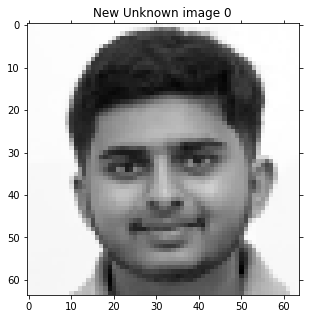

-------------
For new testing image 1:

Detected image from training images index 14 and distance value 53890902.467777275
Face detected, but did not find it in the dataset

The prediction is correct


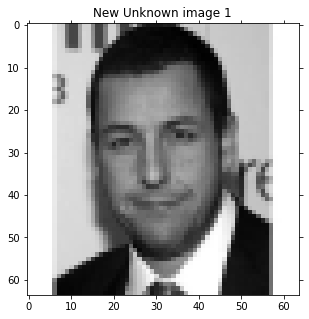

-------------
For new testing image 2:

Detected image from training images index 132 and distance value 42356269.99026628
Face detected, but did not find it in the dataset

The prediction is correct


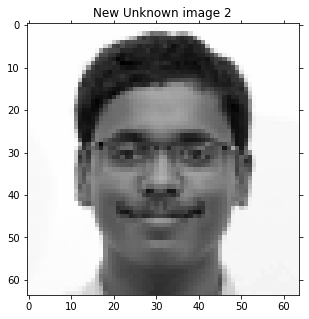

-------------
For new testing image 3:

Detected image from training images index 70 and distance value 53194753.008905225
Face detected, but did not find it in the dataset

The prediction is correct


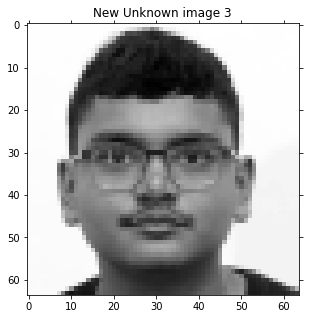

-------------
For new testing image 4:

Detected image from training images index 132 and distance value 40490284.860259816
Face detected, but did not find it in the dataset

The prediction is correct


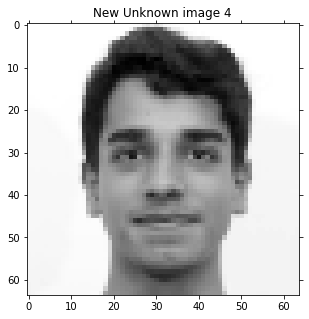

-------------
For new testing image 5:

Detected image from training images index 42 and distance value 55457249.541138574
Face not detected

The prediction is correct


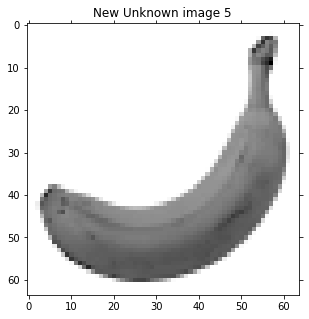

-------------
For new testing image 6:

Detected image from training images index 14 and distance value 59135632.23573266
Face not detected

The prediction is correct


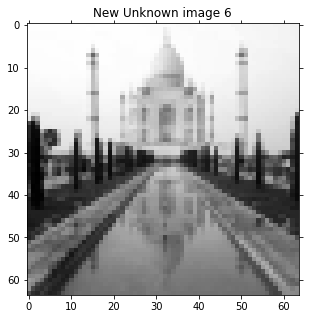

-------------
Accuracy: 7/7 = 100.0%


In [18]:
correct_pred = 0
for idx, img in enumerate(new_testing_im):
    print(f"For new testing image {idx}:\n")
    label, im = recogniser(img, new_testing_label[idx], proj_data, w, 3, True)
    if label == new_testing_label[idx]:
        print("\nThe prediction is correct")
        correct_pred += 1
    else:
        print("\nThe prediction is incorrect")
    plt.figure(figsize=(ROW_SIZE,ROW_SIZE))
    plt.imshow(img, cmap='gray')
    plt.title(f'New Unknown image {idx}')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='on',left='off', which='both')
    plt.show()
    print("-------------")

print('Accuracy: {}/{} = {}%'.format(correct_pred, new_testing_im.shape[0], correct_pred/new_testing_im.shape[0]*100))
